In [1]:
import sys
# add didgelab source code to path
sys.path.append('../../')

from cad.calc.parameters import MutationParameterSet, MutationParameter
from cad.ui.visualization import DidgeVisualizer
import numpy as np
from cad.calc.geo import Geo, geotools
import sys
import random

In [139]:
class SintraShape(MutationParameterSet):
    
    def __init__(self):
        
        MutationParameterSet.__init__(self)

        self.d1=32
        self.n_segments = 10
        
        self.add_param("length", 1520, 1600)
        self.add_param("bellsize", 65, 80)
        self.add_param("power", 1,2)
        
        

    def make_geo(self):
        length = self.get_value("length")
        bellsize = self.get_value("bellsize")

        x = length*np.arange(self.n_segments+1)/self.n_segments
    
        y= np.arange(self.n_segments+1)/self.n_segments
        p = self.get_value("power")
        y = np.power(y, p)
        y = np.power(y, p)
        y = np.power(y, p)
        y = self.d1 + y*(bellsize - self.d1)
        
        geo = list(zip(x,y))
        
        return Geo(geo)
        
father = SintraShape()
#geo = father.make_geo()
#DidgeVisualizer.vis_didge(geo)


# compute 50 cadsds and get the distribution of their fundamental notes
from cad.calc.mutation import ExploringMutator
import pandas as pd
import tqdm
mutator = ExploringMutator()

mutants = []
geos = []

n=50
pbar = tqdm.tqdm(total=n)
for i in range(n):
    mutant = father.copy()
    mutator.mutate(mutant)
    mutants.append(mutant)
    geo = mutant.make_geo()
    geos.append(geo)
    geo.get_cadsd().get_notes()
    pbar.update()
    
from cad.calc.conv import note_to_freq

fD = note_to_freq(-31)

def get_closest_note(geo, f):
    notes = geo.get_cadsd().get_notes()
    freqs = np.abs(np.log2(notes.freq) - np.log2(f))
    return notes.iloc[np.argmin(freqs)]

fundamentals = [get_closest_note(g, fD) for g in geos]
fundamentals = pd.DataFrame(fundamentals)
fundamentals["note-name"].value_counts()


100%|███████████████████████████████████████████████████| 50/50 [15:08:14<00:00, 1089.90s/it]

100%|████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.17it/s]

C1     21
D1     16
C#1    11
D#1     2
Name: note-name, dtype: int64

<AxesSubplot: xlabel='length', ylabel='note-name'>

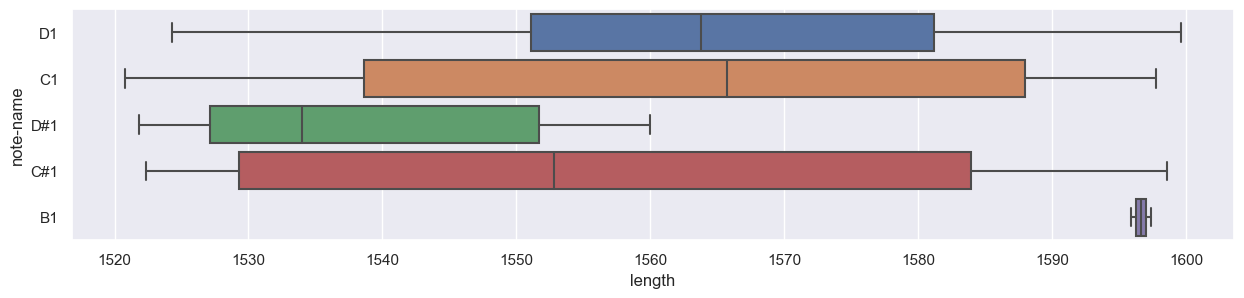

100%|████████████████████████████████████████████████████████| 50/50 [00:22<00:00, 14.32it/s]

In [34]:
import seaborn as sns
fundamentals["length"] = [g.geo[-1][0] for g in geos]
sns.boxplot(data=fundamentals, x="length", y="note-name")

In [134]:
from cad.calc.loss import LossFunction
from cad.calc.conv import note_to_freq

class SintraLoss(LossFunction):
        
    def __init__(self):
        LossFunction.__init__(self)
        
        base_note = -31
        self.target_notes = np.array([0,16,24])+base_note
        self.target_freqs = np.log2(note_to_freq(self.target_notes))
        self.multiples = np.arange(1,15)*note_to_freq(base_note)

    def get_deviations(self, freq, reference):
        
        deviations = []
        for f in freq:
            d = [np.abs(r-f) for r in reference]
            deviations.append(np.min(d))
        return deviations
        
    def get_loss(self, geo, context=None):
        
        notes = geo.get_cadsd().get_notes()
        freqs = np.log2(list(notes.freq))
        toots = freqs[0:3]
        others = freqs[3:]
        
        deviations = self.get_deviations(toots, self.target_freqs)
        fundamental_loss = deviations[0]
        fundamental_loss *= 30
        toots_loss = np.sum(deviations[1:])/2
        toots_loss *= 10

        deviations = self.get_deviations(others, self.multiples)
        multiple_loss = (np.sum(deviations) / len(deviations))
        multiple_loss = multiple_loss/100
        
        loss = {
            "loss": fundamental_loss + toots_loss + multiple_loss,
            "fundamental_loss": fundamental_loss,
            "toots_loss": toots_loss,
            "multiple_loss": multiple_loss
        }
        return loss
        
loss = SintraLoss()
loss.get_loss(geos[0])

{'loss': 2.8000272194967684,
 'fundamental_loss': 1.3829868927721378,
 'toots_loss': 0.7760325684023384,
 'multiple_loss': 0.6410077583222922}

In [135]:
pbar = tqdm.tqdm(total=n)
geos = []
losses = []
for i in range(n):
    mutant = father.copy()
    mutator.mutate(mutant)
    mutants.append(mutant)

    geo = mutant.make_geo()
    losses.append(loss.get_loss(geo))
    geos.append(geo)
    pbar.update()
    

 98%|██████████████████████████████████████████████████████▉ | 49/50 [00:03<00:00, 14.17it/s]

In [136]:
mini = np.argmin([l["loss"] for l in losses])
losses[mini]

{'loss': 1.4505849462769134,
 'fundamental_loss': 0.04937893935120563,
 'toots_loss': 0.760081388231657,
 'multiple_loss': 0.6411246186940508}

In [137]:
geos[mini].get_cadsd().get_notes()


,freq,impedance,rel_imp,note-number,cent-diff,note-name
1694,73.5,2.879490e+07,1.000000,-31,-1.975158,D1
144,174.0,8.599337e+06,0.298641,-16,6.099461,F2
251,281.0,4.245925e+06,0.147454,-8,-23.679928,C#3
360,390.0,2.459066e+06,0.085399,-2,8.835280,G3
469,499.0,1.598238e+06,0.055504,2,-17.843550,B4
578,608.0,1.120977e+06,0.038930,6,40.118640,D#4
688,718.0,8.328412e+05,0.028923,8,-47.776384,F4
795,825.0,6.473542e+05,0.022482,11,11.731285,G#4
879,909.0,5.605515e+05,0.019467,13,43.867875,A#5


100%|████████████████████████████████████████████████████████| 50/50 [00:23<00:00, 14.17it/s]

In [7]:
# compute 50 cadsds and get the distribution of their fundamental notes
from cad.calc.mutation import ExploringMutator
import pandas as pd
import tqdm
mutator = ExploringMutator()

mutants = []
geos = []

n=50
pbar = tqdm.tqdm(total=n)
for i in range(n):
    mutant = father.copy()
    mutator.mutate(mutant)
    mutants.append(mutant)
    geo = mutant.make_geo()
    geos.append(geo)
    geo.get_cadsd().get_notes()
    pbar.update()
    
from cad.calc.conv import note_to_freq

fD = note_to_freq(-31)

def get_closest_note(geo, f):
    notes = geo.get_cadsd().get_notes()
    freqs = np.abs(np.log2(notes.freq) - np.log2(f))
    return notes.iloc[np.argmin(freqs)]

fundamentals = [get_closest_note(g, fD) for g in geos]
fundamentals = pd.DataFrame(fundamentals)
fundamentals["note-name"].value_counts()


  0%|                                                                   | 0/50 [00:22<?, ?it/s]

 98%|████████████████████████████████████████████████████████▊ | 49/50 [00:03<00:00, 13.71it/s]

B1     19
C1     12
D1      8
A#1     6
D#1     3
C#1     2
Name: note-name, dtype: int64


100%|██████████████████████████████████████████████████████████| 50/50 [00:17<00:00, 13.71it/s]

<AxesSubplot: >

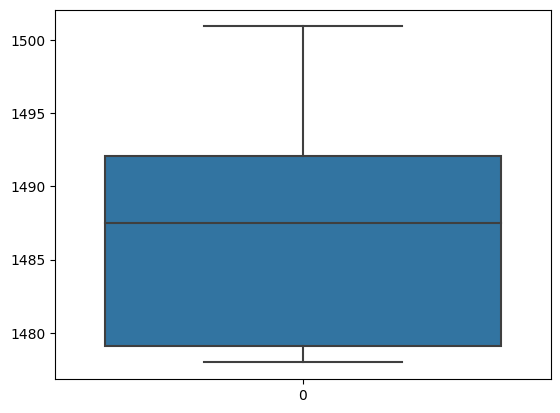

In [6]:
import pickle
from cad.calc.parameters import SintraShape
pkl = "../../../../evolutions/sintra2/results/1.pkl"
data = pickle.load(open(pkl, "rb"))

l=[]
for i in range(20):
    geo = data.get(i).geo
    l.append(geo.geo[-1][0])
    
import seaborn as sns

sns.boxplot(l)